In [1]:
import poppy
from poppy import u
import numpy as np
import OpenEXR
import astropy

def save_openexr(hdulist, filename):
  if len(hdulist) > 1:
    r_img_data = np.asarray(hdulist[0].data, dtype=np.float32).tobytes()
    g_img_data = np.asarray(hdulist[1].data, dtype=np.float32).tobytes()
    b_img_data = np.asarray(hdulist[2].data, dtype=np.float32).tobytes()
    header = OpenEXR.Header(hdulist[0].shape[0], hdulist[0].shape[1])
    out_exr = OpenEXR.OutputFile(filename, header)
    out_exr.writePixels({
        'R': r_img_data,
        'G': g_img_data,
        'B': b_img_data,
    })
  else:
    r_img_data = np.asarray(hdulist[0].data, dtype=np.float32).tobytes()
    header = OpenEXR.Header(hdulist[0].shape[0], hdulist[0].shape[1])
    out_exr = OpenEXR.OutputFile(filename, header)
    out_exr.writePixels({
        'R': r_img_data,
    })

def save_rgb_psf(osys: poppy.OpticalSystem, filename):
  r_psf = osys.calc_psf(0.61e-6)
  g_psf = osys.calc_psf(0.56e-6)
  b_psf = osys.calc_psf(0.47e-6)
  psf = astropy.io.fits.hdu.HDUList([r_psf[0], g_psf[0], b_psf[0]])
  poppy.display_psf(psf, title=filename)

  save_openexr(psf, filename)

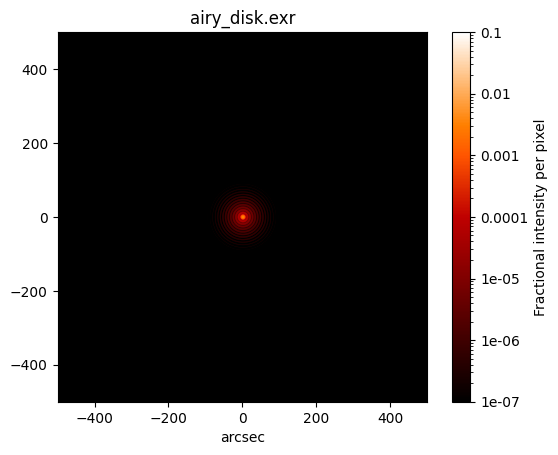

In [2]:
osys = poppy.OpticalSystem()
osys.add_pupil( poppy.CircularAperture(radius=9*u.mm))    # pupil radius in meters
osys.add_detector(pixelscale=1, fov_arcsec=1000.0)  # image plane coordinates in arcseconds
save_rgb_psf(osys, "airy_disk.exr")

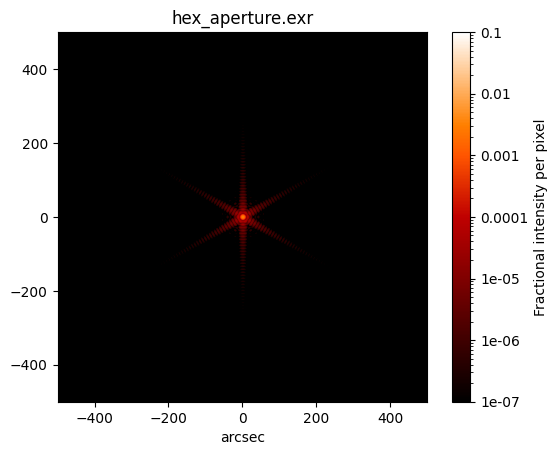

In [3]:
osys = poppy.OpticalSystem()
osys.add_pupil( poppy.HexagonAperture(diameter=18*u.mm))    # pupil radius in meters
osys.add_detector(pixelscale=1, fov_arcsec=1000.0)  # image plane coordinates in arcseconds
save_rgb_psf(osys, "hex_aperture.exr")

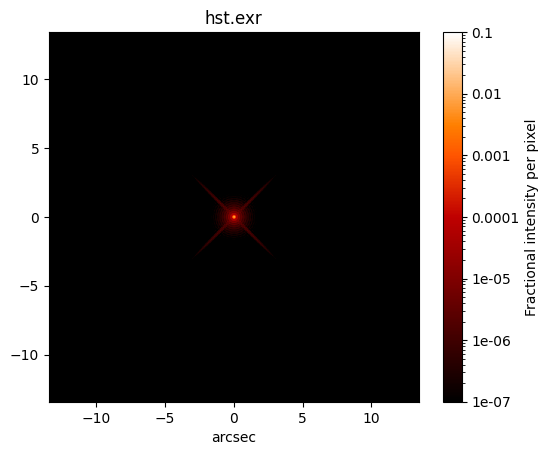

In [4]:
# HST example - Following example in PROPER Manual V2.0 page 49.
diam = 2.4 * u.m
fl_pri = 5.52085 * u.m
d_pri_sec = 4.907028205 * u.m
fl_sec = -0.6790325 * u.m
d_sec_to_focus = 6.3919974 * u.m

hst = poppy.FresnelOpticalSystem(pupil_diameter=2.4*u.m, npix=512, beam_ratio=0.25)
m1 = poppy.QuadraticLens(fl_pri, name='Primary')
m2 = poppy.QuadraticLens(fl_sec, name='Secondary')

hst.add_optic(poppy.CircularAperture(radius=diam.value/2))
hst.add_optic(poppy.SecondaryObscuration(secondary_radius=0.396,
                                 support_width=0.0264,
                                 support_angle_offset=45.0))
hst.add_optic(m1)
hst.add_optic(m2, distance=d_pri_sec)
hst.add_optic(poppy.ScalarTransmission(planetype=poppy.fresnel.PlaneType.image, name='focus'), distance=d_sec_to_focus);
save_rgb_psf(hst, "hst.exr")